# ML predicting Arrival Delays

- This notebook uses a subset of data (5000 flights) of domestic(USA) flights in 2006.
- A summary of this part of the project and interpretation of results can be viewed at the bottom of the workbook.
- The following notebook does not use Departure Delay as a feature for modelling.

## Notebook Aims:
- Create an effective model for predicting the class of arrival delay (ArrDelayClass - The delay in arriving at destination relative to the scheduled arrival time.)
- What features are most important for determining the magnitude of arrival delay?
- Create 2 sets of models (SEE ADDITIONAL NOTEBOOK). One without using DepDelay as a feature. (When you book a flight months in advance you do not know how delayed your flight is going to be - This is considered future information). The 2nd model will use this feature so that expected arrival delay can be calculated in real-time.
- Sets of models will include linear regression, KNN, Random Forests, AdaBoost, Gradient Boost.


In [1]:
#Importing relevant libraries 

import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
cwd = os.getcwd()
os.chdir(r"c:\Users\oskar\Documents\Projects\Portfolio Projects")
cwd

'c:\\Users\\oskar\\Documents\\Projects\\Portfolio Projects\\Jupyter Notebooks'

## Select number of data points to take from 2006 Travel Data

- The models created will use 5000 flights data as it is computationally expensive with more data points

In [3]:
plane_df = pd.read_csv("5000flights.csv", index_col=0)
plane_df.head(5)

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Season,CRSDepTime,CRSDepTimeMins_after_0000,CRSDepTimeFrame,CRSElapsedTime,CRSArrTime,UniqueCarrier,origin_runways,destination_runways,total_runways,USair_congestion,total_flights_origin,total_flights_destination,DepDelay,ArrDelay,ArrDelayClass,Date
0,CVG,CMH,116.0,1,19,6,Summer,10:30:00,630,Morning,48.0,1118,OH,4,2,6,18,2,2,5.0,2.0,Slightly delayed,2006-06-19
1,ATL,SGF,563.0,7,30,7,Summer,20:35:00,1235,Evening,112.0,2127,EV,5,2,7,17,2,1,153.0,136.0,Excessively delayed,2006-07-30
2,PBI,BDL,1133.0,1,31,7,Summer,12:00:00,720,Afternoon,170.0,1450,DL,3,3,6,12,2,1,0.0,-4.0,On-time,2006-07-31
3,PIT,PHL,267.0,3,27,12,Winter,16:50:00,1010,Afternoon,70.0,1800,US,4,4,8,19,1,1,-4.0,-11.0,On-time,2006-12-27
4,ORD,ANC,2846.0,7,23,7,Summer,19:20:00,1160,Evening,399.0,2259,AS,11,3,14,12,1,2,8.0,-2.0,On-time,2006-07-23


# Model 1 : Predicting Delays in Advance (Removing the "DepDelay" feature)

## PreProcessing
- Majority of feature engineering occurred in previous notebook (Season, CRSDepTimeMins_after_0000, CRSDepTimeFrame, origin_runways, destination_runways, total_runways, Date)
- Missing Values?
- What are the data types? 
- Selecting Features for modelling (removing redundant features) + PCA can be used when we have no strong candidates for elimination. (should test with and without PCA to show influence)
- Train and Test Split (can i stratify the feature variables, eg season?)
- Standardizing Data (continuous and numeric data should appear normally distributed. sklearn assumes normality. Non-Normal Data introduces bias which worsens the predictive capabilities of a model.Especially important for models taking place in linear space (Linear Regression, KNN), less important for CARTS and Boosting Techniques. Standardization prevents features with larger magnitudes from dominating models that occur in linear space, and will not negatively impact CARTS effectiveness.)
- Compare models with and without Principal Componenet Analysis.
   
- Optimising Models (GridSearch)




## Feature Engineering
- The previous notebook titled "Delay Prediction - EDA", shows the process behind extracting new features from the pre-existing set of available features.
- I have also decided to converted scheduled departure and arrival times into their respective departure and arrival hours.

In [4]:
plane_df.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Season,CRSDepTime,CRSDepTimeMins_after_0000,CRSDepTimeFrame,CRSElapsedTime,CRSArrTime,UniqueCarrier,origin_runways,destination_runways,total_runways,USair_congestion,total_flights_origin,total_flights_destination,DepDelay,ArrDelay,ArrDelayClass,Date
0,CVG,CMH,116.0,1,19,6,Summer,10:30:00,630,Morning,48.0,1118,OH,4,2,6,18,2,2,5.0,2.0,Slightly delayed,2006-06-19
1,ATL,SGF,563.0,7,30,7,Summer,20:35:00,1235,Evening,112.0,2127,EV,5,2,7,17,2,1,153.0,136.0,Excessively delayed,2006-07-30
2,PBI,BDL,1133.0,1,31,7,Summer,12:00:00,720,Afternoon,170.0,1450,DL,3,3,6,12,2,1,0.0,-4.0,On-time,2006-07-31
3,PIT,PHL,267.0,3,27,12,Winter,16:50:00,1010,Afternoon,70.0,1800,US,4,4,8,19,1,1,-4.0,-11.0,On-time,2006-12-27
4,ORD,ANC,2846.0,7,23,7,Summer,19:20:00,1160,Evening,399.0,2259,AS,11,3,14,12,1,2,8.0,-2.0,On-time,2006-07-23


In [5]:
plane_df["CRSDepTime"] = pd.to_datetime(plane_df["CRSDepTime"]) #converting to a datetime object
plane_df["CRSDepTime"].dtype
plane_df["CRSDepHour"] = plane_df["CRSDepTime"].dt.hour #will be converted to categorical as there is a non linear relationship between leaving time and arrival delays. (Due to the cyclical nature of a day.)

- The CRSArrTime is an integer dtype. I want to make sure any non 4 number "times" are preceded by 0's so that they can later be converted to a datetime object, which can then be used to extract the hour.

In [9]:
plane_df["CRSArrTime"] = plane_df["CRSArrTime"].astype(str).str.zfill(4)

plane_df["CRSArrHour"] = pd.to_datetime(plane_df["CRSArrTime"], format='%H%M').dt.hour

plane_df["CRSArrHour"].head()

0    11
1    21
2    14
3    18
4    22
Name: CRSArrHour, dtype: int64

## Missing Values

In [7]:
plane_df.isna().sum()

Origin                       0
Dest                         0
Distance                     0
DayOfWeek                    0
DayofMonth                   0
Month                        0
Season                       0
CRSDepTime                   0
CRSDepTimeMins_after_0000    0
CRSDepTimeFrame              0
CRSElapsedTime               0
CRSArrTime                   0
UniqueCarrier                0
origin_runways               0
destination_runways          0
total_runways                0
USair_congestion             0
total_flights_origin         0
total_flights_destination    0
DepDelay                     0
ArrDelay                     0
ArrDelayClass                0
Date                         0
CRSDepHour                   0
CRSArrHour                   0
dtype: int64

## Selecting Data Types

In [11]:
plane_df.dtypes

Origin                               object
Dest                                 object
Distance                            float64
DayOfWeek                             int64
DayofMonth                            int64
Month                                 int64
Season                               object
CRSDepTime                   datetime64[ns]
CRSDepTimeMins_after_0000             int64
CRSDepTimeFrame                      object
CRSElapsedTime                      float64
CRSArrTime                           object
UniqueCarrier                        object
origin_runways                        int64
destination_runways                   int64
total_runways                         int64
USair_congestion                      int64
total_flights_origin                  int64
total_flights_destination             int64
DepDelay                            float64
ArrDelay                            float64
ArrDelayClass                        object
Date                            

- We can convert many of these to categorical data types to make our model more efficiently/use less memory. Also makes it easier to create dummy variables.

In [12]:
plane_df.columns
arr_pred1 = plane_df[['Origin', 'Dest', 'Distance', 'DayOfWeek', 'DayofMonth', 'Month',
       'Season','CRSDepHour','CRSDepTimeFrame', 'CRSElapsedTime',"CRSArrHour" , 'UniqueCarrier', 'origin_runways',
       'destination_runways', 'total_runways', 'USair_congestion',"total_flights_origin","total_flights_destination", 'ArrDelay', 'ArrDelayClass']]
       
#created a new dataframe without departure delay + removing duplicated info such as departure and arrival times, replacing with the new departure and arrival hour.

In [13]:
#selecting the columns that I would like to be categorical type.
cat_cols = ['Origin', 'Dest', 'DayOfWeek', 'DayofMonth', 'Month', 'Season', 'CRSDepTimeFrame', 'UniqueCarrier', "CRSDepHour", "CRSArrHour", "ArrDelayClass"]

for col in arr_pred1.columns:
    if col in cat_cols:
        arr_pred1.loc[:, col] = arr_pred1[col].astype("category")


C:\Users\oskar\AppData\Local\Temp\ipykernel_17600\8953299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr_pred1.loc[:, col] = arr_pred1[col].astype("category")
C:\Users\oskar\AppData\Local\Temp\ipykernel_17600\8953299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr_pred1.loc[:, col] = arr_pred1[col].astype("category")
C:\Users\oskar\AppData\Local\Temp\ipykernel_17600\8953299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [14]:
arr_pred1.dtypes

Origin                       category
Dest                         category
Distance                      float64
DayOfWeek                    category
DayofMonth                   category
Month                        category
Season                       category
CRSDepHour                   category
CRSDepTimeFrame              category
CRSElapsedTime                float64
CRSArrHour                   category
UniqueCarrier                category
origin_runways                  int64
destination_runways             int64
total_runways                   int64
USair_congestion                int64
total_flights_origin            int64
total_flights_destination       int64
ArrDelay                      float64
ArrDelayClass                category
dtype: object

In [15]:
arr_pred1.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Season,CRSDepHour,CRSDepTimeFrame,CRSElapsedTime,CRSArrHour,UniqueCarrier,origin_runways,destination_runways,total_runways,USair_congestion,total_flights_origin,total_flights_destination,ArrDelay,ArrDelayClass
0,CVG,CMH,116.0,1,19,6,Summer,10,Morning,48.0,11,OH,4,2,6,18,2,2,2.0,Slightly delayed
1,ATL,SGF,563.0,7,30,7,Summer,20,Evening,112.0,21,EV,5,2,7,17,2,1,136.0,Excessively delayed
2,PBI,BDL,1133.0,1,31,7,Summer,12,Afternoon,170.0,14,DL,3,3,6,12,2,1,-4.0,On-time
3,PIT,PHL,267.0,3,27,12,Winter,16,Afternoon,70.0,18,US,4,4,8,19,1,1,-11.0,On-time
4,ORD,ANC,2846.0,7,23,7,Summer,19,Evening,399.0,22,AS,11,3,14,12,1,2,-2.0,On-time


## Selecting Features for Modelling

- We want to remove strongly correlated features, duplicated features, and any large amounts of noise
- The correlation matrix below suggests that Distance and Scheduled Journey time ("CRSElapsedTime") are highly correlated, so I will drop the latter.

In [16]:
arr_pred1.corr()

,Distance,CRSElapsedTime,origin_runways,destination_runways,total_runways,USair_congestion,total_flights_origin,total_flights_destination,ArrDelay
Distance,1.000000,0.985685,0.030938,0.076015,0.080743,-0.003726,0.020639,0.076224,-0.013341
CRSElapsedTime,0.985685,1.000000,0.035307,0.095844,0.098908,-0.006322,0.017680,0.086319,-0.005075
origin_runways,0.030938,0.035307,1.000000,-0.142333,0.676935,0.029439,0.337910,-0.109301,0.059128
destination_runways,0.076015,0.095844,-0.142333,1.000000,0.632199,-0.001926,-0.103174,0.363147,0.038914
total_runways,0.080743,0.098908,0.676935,0.632199,1.000000,0.021611,0.187786,0.184482,0.075221
USair_congestion,-0.003726,-0.006322,0.029439,-0.001926,0.021611,1.000000,0.212838,0.215934,0.055856
total_flights_origin,0.020639,0.017680,0.337910,-0.103174,0.187786,0.212838,1.000000,-0.031657,0.048489
total_flights_destination,0.076224,0.086319,-0.109301,0.363147,0.184482,0.215934,-0.031657,1.000000,0.027555
ArrDelay,-0.013341,-0.005075,0.059128,0.038914,0.075221,0.055856,0.048489,0.027555,1.000000


In [17]:
arr_pred1 = arr_pred1.drop("CRSElapsedTime", axis=1)
arr_pred1.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Season,CRSDepHour,CRSDepTimeFrame,CRSArrHour,UniqueCarrier,origin_runways,destination_runways,total_runways,USair_congestion,total_flights_origin,total_flights_destination,ArrDelay,ArrDelayClass
0,CVG,CMH,116.0,1,19,6,Summer,10,Morning,11,OH,4,2,6,18,2,2,2.0,Slightly delayed
1,ATL,SGF,563.0,7,30,7,Summer,20,Evening,21,EV,5,2,7,17,2,1,136.0,Excessively delayed
2,PBI,BDL,1133.0,1,31,7,Summer,12,Afternoon,14,DL,3,3,6,12,2,1,-4.0,On-time
3,PIT,PHL,267.0,3,27,12,Winter,16,Afternoon,18,US,4,4,8,19,1,1,-11.0,On-time
4,ORD,ANC,2846.0,7,23,7,Summer,19,Evening,22,AS,11,3,14,12,1,2,-2.0,On-time


## Splitting into train and test splits

In [18]:
X = arr_pred1.drop(["ArrDelay", "ArrDelayClass"], axis=1)
y = arr_pred1["ArrDelayClass"] #y is the target

## Dealing with Skewed Distributions

- The histograms below show that some features are left skewed
- Algorithms such as Linear Regression are parametric and assume that underlying ditributions are normal.
- np.log1p() will not be applied to the target variable (ArrDelay) as it contains negative values. To deal with this, sinh from numpy will be used (as even 0 in this column holds valuable info - it holds valuable information)
- Using sinh is useful as a back transformation can occur later on, with arcsinh, which can make it more interpretable for human audiences

- New columns will be created for the data that needs to be transformed
- It appears that np.log1p() doesnt transform the last 3 columns very effectively. I will keep them transformed for consistency purposes.

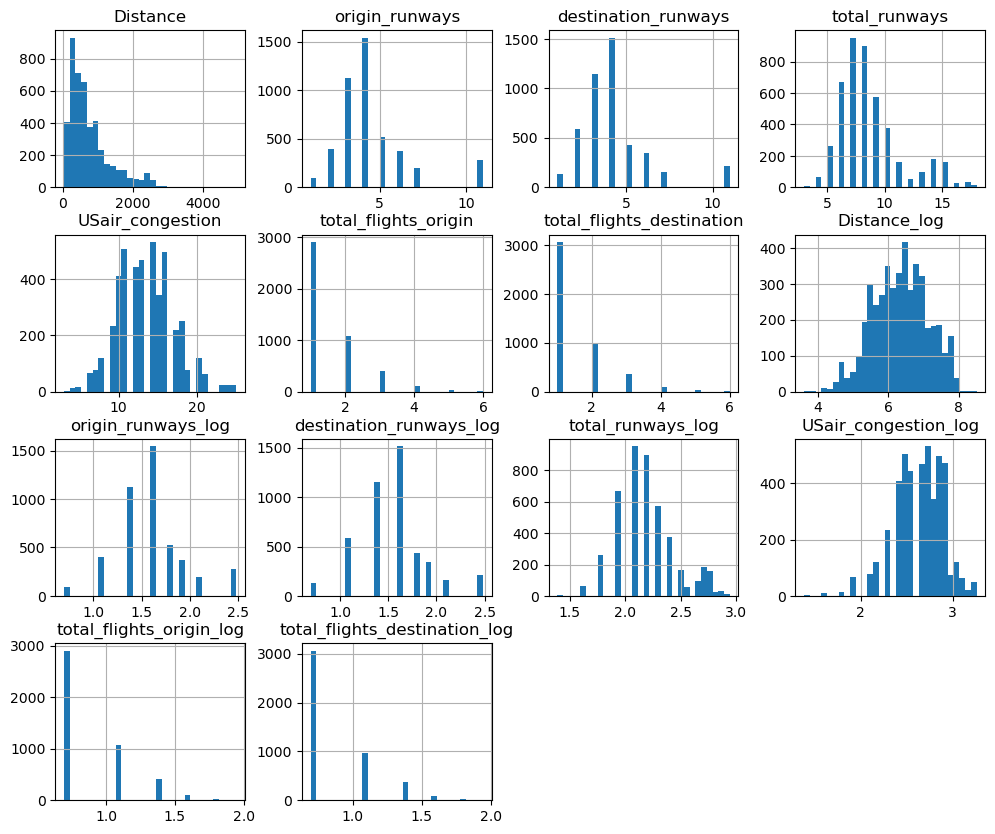

Distance                         1.560509
origin_runways                   1.740667
destination_runways              1.807815
total_runways                    1.178276
USair_congestion                 0.325622
total_flights_origin             1.795971
total_flights_destination        1.965427
Distance_log                    -0.122303
origin_runways_log               0.415248
destination_runways_log          0.336391
total_runways_log                0.455226
USair_congestion_log            -0.553993
total_flights_origin_log         1.200941
total_flights_destination_log    1.362923
dtype: float64


In [19]:
skewed_cols = ["Distance", "origin_runways", "destination_runways", "total_runways", "USair_congestion","total_flights_origin","total_flights_destination"]

for col in skewed_cols:
    X[col + "_log"] = np.log1p(X[col]) #np.log1p() can be transformed before or after splitting into train and test sets - it doesnt "leak"

X.hist(bins=30, figsize=(12,10))
plt.show()

skew = X.skew()
print(skew)

### Dropping original columns that are now transformed 

In [20]:
original_cols_drop = ["Distance", "origin_runways", "destination_runways", "total_runways","USair_congestion","total_flights_origin","total_flights_destination"]
X = X.drop(original_cols_drop, axis=1)

### Retrieve Dummies for categorical variables

In [21]:
X = pd.get_dummies(X)
X.head()


,Distance_log,origin_runways_log,destination_runways_log,total_runways_log,USair_congestion_log,total_flights_origin_log,total_flights_destination_log,Origin_ABQ,Origin_ALB,Origin_ANC,Origin_ATL,Origin_AUS,Origin_BDL,Origin_BHM,Origin_BNA,Origin_BOI,Origin_BOS,Origin_BTR,Origin_BUF,Origin_BUR,Origin_BWI,Origin_CAK,Origin_CLE,Origin_CLT,Origin_CMH,Origin_COS,Origin_CVG,Origin_DAL,Origin_DAY,Origin_DCA,Origin_DEN,Origin_DFW,Origin_DSM,Origin_DTW,Origin_ELP,Origin_EWR,Origin_FAT,Origin_FLL,Origin_GPT,Origin_GRR,Origin_GSO,Origin_GSP,Origin_HNL,Origin_HOU,Origin_IAD,Origin_IAH,Origin_ICT,Origin_IND,Origin_ISP,Origin_JAX,Origin_JFK,Origin_LAS,Origin_LAX,Origin_LBB,Origin_LGA,Origin_LGB,Origin_LIH,Origin_LIT,Origin_MCI,Origin_MCO,Origin_MDW,Origin_MEM,Origin_MHT,Origin_MIA,Origin_MKE,Origin_MRY,Origin_MSN,Origin_MSP,Origin_MSY,Origin_OAK,Origin_OGG,Origin_OKC,Origin_OMA,Origin_ONT,Origin_ORD,Origin_ORF,Origin_PBI,Origin_PDX,Origin_PHF,Origin_PHL,Origin_PHX,Origin_PIT,Origin_PNS,Origin_PVD,Origin_RDU,Origin_RIC,Origin_RNO,Origin_ROC,Origin_RSW,Origin_SAN,Origin_SAT,Origin_SAV,Origin_SBA,Origin_SDF,Origin_SEA,Origin_SFO,Origin_SHV,Origin_SJC,Origin_SJU,Origin_SLC,Origin_SMF,Origin_SNA,Origin_STL,Origin_TPA,Origin_TUL,Origin_TUS,Origin_TYS,Dest_ABE,Dest_ABI,Dest_ABQ,Dest_ACK,Dest_ACT,Dest_ACV,Dest_AEX,Dest_AGS,Dest_ALB,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BFL,Dest_BGM,Dest_BGR,Dest_BHM,Dest_BIL,Dest_BIS,Dest_BMI,Dest_BNA,Dest_BOI,Dest_BOS,Dest_BRO,Dest_BTM,Dest_BTR,Dest_BTV,Dest_BUF,Dest_BUR,Dest_BWI,Dest_BZN,Dest_CAE,Dest_CAK,Dest_CHA,Dest_CHO,Dest_CHS,Dest_CIC,Dest_CID,Dest_CLD,Dest_CLE,Dest_CLT,Dest_CMH,Dest_CMI,Dest_COD,Dest_COS,Dest_CPR,Dest_CRP,Dest_CRW,Dest_CVG,Dest_DAB,Dest_DAL,Dest_DAY,Dest_DBQ,Dest_DCA,Dest_DEN,Dest_DFW,Dest_DRO,Dest_DSM,Dest_DTW,Dest_EGE,Dest_EKO,Dest_ELP,Dest_ERI,Dest_EUG,Dest_EVV,Dest_EWR,Dest_FAI,Dest_FAR,Dest_FAT,Dest_FAY,Dest_FCA,Dest_FLL,Dest_FLO,Dest_FNT,Dest_FSD,Dest_FSM,Dest_FWA,Dest_GEG,Dest_GFK,Dest_GGG,Dest_GJT,Dest_GPT,Dest_GRB,Dest_GRK,Dest_GRR,Dest_GSO,Dest_GSP,Dest_GTF,Dest_GTR,Dest_GUC,Dest_HDN,Dest_HLN,Dest_HNL,Dest_HOU,Dest_HPN,Dest_HRL,Dest_HSV,Dest_IAD,Dest_IAH,Dest_ICT,Dest_IDA,Dest_ILM,Dest_IND,Dest_ISO,Dest_ISP,Dest_ITO,Dest_JAC,Dest_JAN,Dest_JAX,Dest_JFK,Dest_KOA,Dest_LAN,Dest_LAS,Dest_LAX,Dest_LBB,Dest_LCH,Dest_LEX,Dest_LFT,Dest_LGA,Dest_LGB,Dest_LIH,Dest_LIT,Dest_LNK,Dest_LRD,Dest_LSE,Dest_MAF,Dest_MBS,Dest_MCI,Dest_MCN,Dest_MCO,Dest_MDT,Dest_MDW,Dest_MEM,Dest_MFE,Dest_MFR,Dest_MHT,Dest_MIA,Dest_MKE,Dest_MLB,Dest_MLI,Dest_MOB,Dest_MOD,Dest_MOT,Dest_MRY,Dest_MSN,Dest_MSO,Dest_MSP,Dest_MSY,Dest_MYR,Dest_OAK,Dest_OGG,Dest_OKC,Dest_OMA,Dest_ONT,Dest_ORD,Dest_ORF,Dest_OXR,Dest_PBI,Dest_PDX,Dest_PFN,Dest_PHF,Dest_PHL,Dest_PHX,Dest_PIA,Dest_PIH,Dest_PIT,Dest_PNS,Dest_PSC,Dest_PSE,Dest_PSP,Dest_PVD,Dest_PWM,Dest_RAP,Dest_RDD,Dest_RDM,Dest_RDU,Dest_RIC,Dest_RNO,Dest_ROA,Dest_ROC,Dest_RST,Dest_RSW,Dest_SAN,Dest_SAT,Dest_SAV,Dest_SBA,Dest_SBP,Dest_SDF,Dest_SEA,Dest_SFO,Dest_SGF,Dest_SGU,Dest_SHV,Dest_SJC,Dest_SJT,Dest_SJU,Dest_SLC,Dest_SMF,Dest_SMX,Dest_SNA,Dest_SPI,Dest_SPS,Dest_SRQ,Dest_STL,Dest_STT,Dest_SUN,Dest_SWF,Dest_SYR,Dest_TLH,Dest_TOL,Dest_TPA,Dest_TRI,Dest_TUL,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TYS,Dest_VPS,Dest_XNA,Dest_YUM,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,DayofMonth_1,DayofMonth_2,DayofMonth_3,DayofMonth_4,DayofMonth_5,DayofMonth_6,DayofMonth_7,DayofMonth_8,DayofMonth_9,DayofMonth_10,DayofMonth_11,DayofMonth_12,DayofMonth_13,DayofMonth_14,DayofMonth_15,DayofMonth_16,DayofMonth_17,DayofMonth_18,DayofMonth_19,DayofMonth_20,DayofMonth_21,DayofMonth_22,DayofMonth_23,DayofMonth_24,DayofMonth_25,DayofMonth_26,DayofMonth_27,DayofMonth_28,DayofMonth_29,DayofMonth_30,DayofMonth_31,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,CRSDepHour_0,CRSDepHour_1,CRSDepHour_2,CRSDepHour_3

## Splitting + Standardizing Data

- Due to the class imbalance of the flight delay categories, startify=y will be set so that equal proportions of each class are selected in the training and test set, to reduce bias.
- We will also be employing SMOTE in order to generate synthetic samples of the imbalanced/undersampled classes.

- The new column, distance_log appears to be on a slightly greater scale in comparison to the other features, so we will use StandardScaler. (No need to scale y features)
- The test data will only be transformed, not fit to, as this would incur data leakage.

In [22]:
display(y.value_counts())
# Initial data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18, stratify=y)

# Scaling process
scaler = StandardScaler() #initiating scaler

cols_to_scale = ['Distance_log', 'origin_runways_log', 'destination_runways_log', 'total_runways_log','USair_congestion_log','total_flights_origin_log','total_flights_destination_log'] #these columns will be scaled

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Applying scaler
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train_scaled, y_train)
X_test = X_test_scaled

On-time                2478
Slightly delayed       1066
Moderately delayed      679
Excessively delayed     309
Name: ArrDelayClass, dtype: int64

- The above output exemplifies the issue of imbalanced classes.

### Check data before ML

In [23]:
display(X_train.head(2))
display(X_test.head(2))
display(y_train.value_counts(normalize=True))
display(y_test.value_counts(normalize=True))


,Distance_log,origin_runways_log,destination_runways_log,total_runways_log,USair_congestion_log,total_flights_origin_log,total_flights_destination_log,Origin_ABQ,Origin_ALB,Origin_ANC,Origin_ATL,Origin_AUS,Origin_BDL,Origin_BHM,Origin_BNA,Origin_BOI,Origin_BOS,Origin_BTR,Origin_BUF,Origin_BUR,Origin_BWI,Origin_CAK,Origin_CLE,Origin_CLT,Origin_CMH,Origin_COS,Origin_CVG,Origin_DAL,Origin_DAY,Origin_DCA,Origin_DEN,Origin_DFW,Origin_DSM,Origin_DTW,Origin_ELP,Origin_EWR,Origin_FAT,Origin_FLL,Origin_GPT,Origin_GRR,Origin_GSO,Origin_GSP,Origin_HNL,Origin_HOU,Origin_IAD,Origin_IAH,Origin_ICT,Origin_IND,Origin_ISP,Origin_JAX,Origin_JFK,Origin_LAS,Origin_LAX,Origin_LBB,Origin_LGA,Origin_LGB,Origin_LIH,Origin_LIT,Origin_MCI,Origin_MCO,Origin_MDW,Origin_MEM,Origin_MHT,Origin_MIA,Origin_MKE,Origin_MRY,Origin_MSN,Origin_MSP,Origin_MSY,Origin_OAK,Origin_OGG,Origin_OKC,Origin_OMA,Origin_ONT,Origin_ORD,Origin_ORF,Origin_PBI,Origin_PDX,Origin_PHF,Origin_PHL,Origin_PHX,Origin_PIT,Origin_PNS,Origin_PVD,Origin_RDU,Origin_RIC,Origin_RNO,Origin_ROC,Origin_RSW,Origin_SAN,Origin_SAT,Origin_SAV,Origin_SBA,Origin_SDF,Origin_SEA,Origin_SFO,Origin_SHV,Origin_SJC,Origin_SJU,Origin_SLC,Origin_SMF,Origin_SNA,Origin_STL,Origin_TPA,Origin_TUL,Origin_TUS,Origin_TYS,Dest_ABE,Dest_ABI,Dest_ABQ,Dest_ACK,Dest_ACT,Dest_ACV,Dest_AEX,Dest_AGS,Dest_ALB,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BFL,Dest_BGM,Dest_BGR,Dest_BHM,Dest_BIL,Dest_BIS,Dest_BMI,Dest_BNA,Dest_BOI,Dest_BOS,Dest_BRO,Dest_BTM,Dest_BTR,Dest_BTV,Dest_BUF,Dest_BUR,Dest_BWI,Dest_BZN,Dest_CAE,Dest_CAK,Dest_CHA,Dest_CHO,Dest_CHS,Dest_CIC,Dest_CID,Dest_CLD,Dest_CLE,Dest_CLT,Dest_CMH,Dest_CMI,Dest_COD,Dest_COS,Dest_CPR,Dest_CRP,Dest_CRW,Dest_CVG,Dest_DAB,Dest_DAL,Dest_DAY,Dest_DBQ,Dest_DCA,Dest_DEN,Dest_DFW,Dest_DRO,Dest_DSM,Dest_DTW,Dest_EGE,Dest_EKO,Dest_ELP,Dest_ERI,Dest_EUG,Dest_EVV,Dest_EWR,Dest_FAI,Dest_FAR,Dest_FAT,Dest_FAY,Dest_FCA,Dest_FLL,Dest_FLO,Dest_FNT,Dest_FSD,Dest_FSM,Dest_FWA,Dest_GEG,Dest_GFK,Dest_GGG,Dest_GJT,Dest_GPT,Dest_GRB,Dest_GRK,Dest_GRR,Dest_GSO,Dest_GSP,Dest_GTF,Dest_GTR,Dest_GUC,Dest_HDN,Dest_HLN,Dest_HNL,Dest_HOU,Dest_HPN,Dest_HRL,Dest_HSV,Dest_IAD,Dest_IAH,Dest_ICT,Dest_IDA,Dest_ILM,Dest_IND,Dest_ISO,Dest_ISP,Dest_ITO,Dest_JAC,Dest_JAN,Dest_JAX,Dest_JFK,Dest_KOA,Dest_LAN,Dest_LAS,Dest_LAX,Dest_LBB,Dest_LCH,Dest_LEX,Dest_LFT,Dest_LGA,Dest_LGB,Dest_LIH,Dest_LIT,Dest_LNK,Dest_LRD,Dest_LSE,Dest_MAF,Dest_MBS,Dest_MCI,Dest_MCN,Dest_MCO,Dest_MDT,Dest_MDW,Dest_MEM,Dest_MFE,Dest_MFR,Dest_MHT,Dest_MIA,Dest_MKE,Dest_MLB,Dest_MLI,Dest_MOB,Dest_MOD,Dest_MOT,Dest_MRY,Dest_MSN,Dest_MSO,Dest_MSP,Dest_MSY,Dest_MYR,Dest_OAK,Dest_OGG,Dest_OKC,Dest_OMA,Dest_ONT,Dest_ORD,Dest_ORF,Dest_OXR,Dest_PBI,Dest_PDX,Dest_PFN,Dest_PHF,Dest_PHL,Dest_PHX,Dest_PIA,Dest_PIH,Dest_PIT,Dest_PNS,Dest_PSC,Dest_PSE,Dest_PSP,Dest_PVD,Dest_PWM,Dest_RAP,Dest_RDD,Dest_RDM,Dest_RDU,Dest_RIC,Dest_RNO,Dest_ROA,Dest_ROC,Dest_RST,Dest_RSW,Dest_SAN,Dest_SAT,Dest_SAV,Dest_SBA,Dest_SBP,Dest_SDF,Dest_SEA,Dest_SFO,Dest_SGF,Dest_SGU,Dest_SHV,Dest_SJC,Dest_SJT,Dest_SJU,Dest_SLC,Dest_SMF,Dest_SMX,Dest_SNA,Dest_SPI,Dest_SPS,Dest_SRQ,Dest_STL,Dest_STT,Dest_SUN,Dest_SWF,Dest_SYR,Dest_TLH,Dest_TOL,Dest_TPA,Dest_TRI,Dest_TUL,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TYS,Dest_VPS,Dest_XNA,Dest_YUM,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,DayofMonth_1,DayofMonth_2,DayofMonth_3,DayofMonth_4,DayofMonth_5,DayofMonth_6,DayofMonth_7,DayofMonth_8,DayofMonth_9,DayofMonth_10,DayofMonth_11,DayofMonth_12,DayofMonth_13,DayofMonth_14,DayofMonth_15,DayofMonth_16,DayofMonth_17,DayofMonth_18,DayofMonth_19,DayofMonth_20,DayofMonth_21,DayofMonth_22,DayofMonth_23,DayofMonth_24,DayofMonth_25,DayofMonth_26,DayofMonth_27,DayofMonth_28,DayofMonth_29,DayofMonth_30,DayofMonth_31,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,CRSDepHour_0,CRSDepHour_1,CRSDepHour_2,CRSDepHour_3

,Distance_log,origin_runways_log,destination_runways_log,total_runways_log,USair_congestion_log,total_flights_origin_log,total_flights_destination_log,Origin_ABQ,Origin_ALB,Origin_ANC,Origin_ATL,Origin_AUS,Origin_BDL,Origin_BHM,Origin_BNA,Origin_BOI,Origin_BOS,Origin_BTR,Origin_BUF,Origin_BUR,Origin_BWI,Origin_CAK,Origin_CLE,Origin_CLT,Origin_CMH,Origin_COS,Origin_CVG,Origin_DAL,Origin_DAY,Origin_DCA,Origin_DEN,Origin_DFW,Origin_DSM,Origin_DTW,Origin_ELP,Origin_EWR,Origin_FAT,Origin_FLL,Origin_GPT,Origin_GRR,Origin_GSO,Origin_GSP,Origin_HNL,Origin_HOU,Origin_IAD,Origin_IAH,Origin_ICT,Origin_IND,Origin_ISP,Origin_JAX,Origin_JFK,Origin_LAS,Origin_LAX,Origin_LBB,Origin_LGA,Origin_LGB,Origin_LIH,Origin_LIT,Origin_MCI,Origin_MCO,Origin_MDW,Origin_MEM,Origin_MHT,Origin_MIA,Origin_MKE,Origin_MRY,Origin_MSN,Origin_MSP,Origin_MSY,Origin_OAK,Origin_OGG,Origin_OKC,Origin_OMA,Origin_ONT,Origin_ORD,Origin_ORF,Origin_PBI,Origin_PDX,Origin_PHF,Origin_PHL,Origin_PHX,Origin_PIT,Origin_PNS,Origin_PVD,Origin_RDU,Origin_RIC,Origin_RNO,Origin_ROC,Origin_RSW,Origin_SAN,Origin_SAT,Origin_SAV,Origin_SBA,Origin_SDF,Origin_SEA,Origin_SFO,Origin_SHV,Origin_SJC,Origin_SJU,Origin_SLC,Origin_SMF,Origin_SNA,Origin_STL,Origin_TPA,Origin_TUL,Origin_TUS,Origin_TYS,Dest_ABE,Dest_ABI,Dest_ABQ,Dest_ACK,Dest_ACT,Dest_ACV,Dest_AEX,Dest_AGS,Dest_ALB,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BFL,Dest_BGM,Dest_BGR,Dest_BHM,Dest_BIL,Dest_BIS,Dest_BMI,Dest_BNA,Dest_BOI,Dest_BOS,Dest_BRO,Dest_BTM,Dest_BTR,Dest_BTV,Dest_BUF,Dest_BUR,Dest_BWI,Dest_BZN,Dest_CAE,Dest_CAK,Dest_CHA,Dest_CHO,Dest_CHS,Dest_CIC,Dest_CID,Dest_CLD,Dest_CLE,Dest_CLT,Dest_CMH,Dest_CMI,Dest_COD,Dest_COS,Dest_CPR,Dest_CRP,Dest_CRW,Dest_CVG,Dest_DAB,Dest_DAL,Dest_DAY,Dest_DBQ,Dest_DCA,Dest_DEN,Dest_DFW,Dest_DRO,Dest_DSM,Dest_DTW,Dest_EGE,Dest_EKO,Dest_ELP,Dest_ERI,Dest_EUG,Dest_EVV,Dest_EWR,Dest_FAI,Dest_FAR,Dest_FAT,Dest_FAY,Dest_FCA,Dest_FLL,Dest_FLO,Dest_FNT,Dest_FSD,Dest_FSM,Dest_FWA,Dest_GEG,Dest_GFK,Dest_GGG,Dest_GJT,Dest_GPT,Dest_GRB,Dest_GRK,Dest_GRR,Dest_GSO,Dest_GSP,Dest_GTF,Dest_GTR,Dest_GUC,Dest_HDN,Dest_HLN,Dest_HNL,Dest_HOU,Dest_HPN,Dest_HRL,Dest_HSV,Dest_IAD,Dest_IAH,Dest_ICT,Dest_IDA,Dest_ILM,Dest_IND,Dest_ISO,Dest_ISP,Dest_ITO,Dest_JAC,Dest_JAN,Dest_JAX,Dest_JFK,Dest_KOA,Dest_LAN,Dest_LAS,Dest_LAX,Dest_LBB,Dest_LCH,Dest_LEX,Dest_LFT,Dest_LGA,Dest_LGB,Dest_LIH,Dest_LIT,Dest_LNK,Dest_LRD,Dest_LSE,Dest_MAF,Dest_MBS,Dest_MCI,Dest_MCN,Dest_MCO,Dest_MDT,Dest_MDW,Dest_MEM,Dest_MFE,Dest_MFR,Dest_MHT,Dest_MIA,Dest_MKE,Dest_MLB,Dest_MLI,Dest_MOB,Dest_MOD,Dest_MOT,Dest_MRY,Dest_MSN,Dest_MSO,Dest_MSP,Dest_MSY,Dest_MYR,Dest_OAK,Dest_OGG,Dest_OKC,Dest_OMA,Dest_ONT,Dest_ORD,Dest_ORF,Dest_OXR,Dest_PBI,Dest_PDX,Dest_PFN,Dest_PHF,Dest_PHL,Dest_PHX,Dest_PIA,Dest_PIH,Dest_PIT,Dest_PNS,Dest_PSC,Dest_PSE,Dest_PSP,Dest_PVD,Dest_PWM,Dest_RAP,Dest_RDD,Dest_RDM,Dest_RDU,Dest_RIC,Dest_RNO,Dest_ROA,Dest_ROC,Dest_RST,Dest_RSW,Dest_SAN,Dest_SAT,Dest_SAV,Dest_SBA,Dest_SBP,Dest_SDF,Dest_SEA,Dest_SFO,Dest_SGF,Dest_SGU,Dest_SHV,Dest_SJC,Dest_SJT,Dest_SJU,Dest_SLC,Dest_SMF,Dest_SMX,Dest_SNA,Dest_SPI,Dest_SPS,Dest_SRQ,Dest_STL,Dest_STT,Dest_SUN,Dest_SWF,Dest_SYR,Dest_TLH,Dest_TOL,Dest_TPA,Dest_TRI,Dest_TUL,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TYS,Dest_VPS,Dest_XNA,Dest_YUM,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,DayofMonth_1,DayofMonth_2,DayofMonth_3,DayofMonth_4,DayofMonth_5,DayofMonth_6,DayofMonth_7,DayofMonth_8,DayofMonth_9,DayofMonth_10,DayofMonth_11,DayofMonth_12,DayofMonth_13,DayofMonth_14,DayofMonth_15,DayofMonth_16,DayofMonth_17,DayofMonth_18,DayofMonth_19,DayofMonth_20,DayofMonth_21,DayofMonth_22,DayofMonth_23,DayofMonth_24,DayofMonth_25,DayofMonth_26,DayofMonth_27,DayofMonth_28,DayofMonth_29,DayofMonth_30,DayofMonth_31,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,CRSDepHour_0,CRSDepHour_1,CRSDepHour_2,CRSDepHour_3

Excessively delayed    0.25
Moderately delayed     0.25
On-time                0.25
Slightly delayed       0.25
Name: ArrDelayClass, dtype: float64

On-time                0.546858
Slightly delayed       0.234840
Moderately delayed     0.149945
Excessively delayed    0.068357
Name: ArrDelayClass, dtype: float64

- First version will be with the class imbalanced, but with stratify = y
- 2nd version willy employ SMOTE to try and solve this imbalance (Synthetic Minority Over-sampling Technique)

## Classification Models

## KNN

In [60]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm=confusion_matrix(y_test,y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

metrics = {"\nAccuracy: ":accuracy, "Precision: ":precision, "Recall: ":recall, "F1-Score: ":f1}
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}, {metric_value:.3f}")



Accuracy: , 0.158
Precision: , 0.297
Recall: , 0.278
F1-Score: , 0.162


### KNN Optimisation

In [61]:
param_grid = {"n_neighbors":np.arange(1,100),
              "weights":["uniform", "distance"]}

grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring= "accuracy")
grid_knn.fit(X_train, y_train)

print("Best Params:",grid_knn.best_params_, "\nBest Score:",grid_knn.best_score_, "\nBest Estimator:",grid_knn.best_estimator_)

#Using best params grid model on test data

y_pred = grid_knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

metrics = {"\nAccuracy: ":accuracy, "Precision: ":precision, "Recall: ":recall, "F1-Score: ":f1}
for metric_name, metric_value in metrics.items():
    print(f"Test-Set Metrics : {metric_name} {metric_value:.3f}")


Best Params: {'n_neighbors': 1, 'weights': 'uniform'} 
Best Score: 0.6931062411240309 
Best Estimator: KNeighborsClassifier(n_neighbors=1)
Test-Set Metrics : 
Accuracy:  0.224
Test-Set Metrics : Precision:  0.265
Test-Set Metrics : Recall:  0.275
Test-Set Metrics : F1-Score:  0.213


- This looks like an interesting scenario, because the model performed very well on the training data during cross validation, but relatively poorly on the test set.
- This is most likely due to overfitting, most likely due to the low knn optimal neighbours of 1, which is prone to overfitting.

## Logistic Regression

In [67]:
logreg = LogisticRegression(max_iter=10000)

param_grid = {
    "C": [0.01, 0.2, 0.5, 0.75, 1],
    "penalty": ["l1", "l2"]}

grid_logistic = GridSearchCV(logreg, param_grid, cv=5, scoring="accuracy")
grid_logistic.fit(X_train, y_train)
print("Best Params:",grid_logistic.best_params_, "\nBest Score:",grid_logistic.best_score_, "\nBest Estimator:",grid_logistic.best_estimator_)

#Using best params grid model on test data
y_pred = grid_logistic.predict(X_test)

#save the model for later use.
joblib.dump(grid_logistic, 'logistic_regression_model.pkl')

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

metrics = {"\n Test Set Metrics \nAccuracy: ":accuracy, "Precision: ":precision, "Recall: ":recall, "F1-Score: ":f1}

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}, {metric_value:.3f}")

c:\Users\oskar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\oskar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\oskar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\oskar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

Best Params: {'C': 0.2, 'penalty': 'l2'} 
Best Score: 0.5176774696576113 
Best Estimator: LogisticRegression(C=0.2, max_iter=10000)

 Test Set Metrics 
Accuracy: , 0.517
Precision: , 0.339
Recall: , 0.290
F1-Score: , 0.279


- The training accuracy score was lower than with KNN, however the test accuracy was significantly higher than KNN. This is most likely due to the model not overfitting much as the previous model. 

## Random Forests

In [74]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4]}

grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fitting GridSearchCV 
grid_rf.fit(X_train, y_train)

print("Best Params:",grid_rf.best_params_, "\nBest Score:",grid_rf.best_score_, "\nBest Estimator:",grid_rf.best_estimator_)

#Using best params grid model on test data
y_pred = grid_rf.predict(X_test)
joblib.dump(grid_rf, 'random_forest_model.pkl')

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

metrics = {"----Test Set----\nAccuracy: ":accuracy, "Precision: ":precision, "Recall: ":recall, "F1-Score: ":f1}

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}, {metric_value:.3f}")

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Best Params: {'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 150} 
Best Score: 0.6190800418488271 
Best Estimator: RandomForestClassifier(max_depth=15, n_estimators=150)
----Test Set----
Accuracy: , 0.476
Precision: , 0.476
Recall: , 0.476
F1-Score: , 0.476
                     precision    recall  f1-score   support

Excessively delayed       0.17      0.19      0.18        62
 Moderately delayed       0.22      0.17      0.19       136
            On-time       0.59      0.76      0.66       496
   Slightly delayed       0.20      0.09      0.12       213

           accuracy                           0.48       907
          macro avg       0.30      0.30      0.29       907
       weighted avg       0.42      0.48      0.43       907



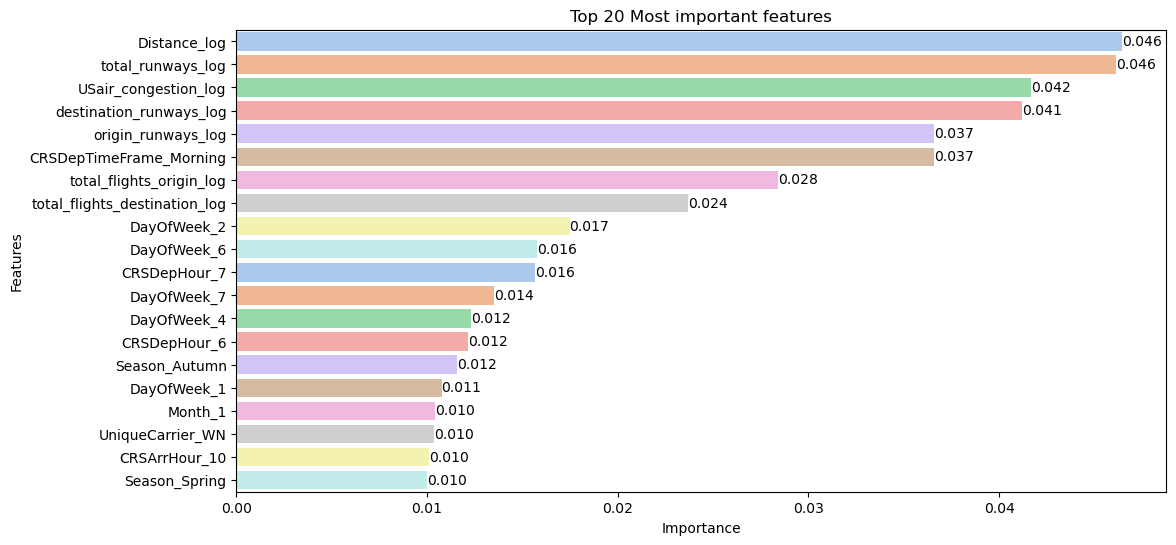

                           feature    importance
0                     Distance_log  4.644977e-02
3                total_runways_log  4.614672e-02
4             USair_congestion_log  4.168602e-02
2          destination_runways_log  4.121328e-02
1               origin_runways_log  3.660983e-02
412        CRSDepTimeFrame_Morning  3.657790e-02
5         total_flights_origin_log  2.840263e-02
6    total_flights_destination_log  2.369995e-02
334                    DayOfWeek_2  1.747423e-02
338                    DayOfWeek_6  1.577499e-02
393                   CRSDepHour_7  1.566736e-02
339                    DayOfWeek_7  1.352624e-02
336                    DayOfWeek_4  1.232749e-02
392                   CRSDepHour_6  1.215187e-02
383                  Season_Autumn  1.155278e-02
333                    DayOfWeek_1  1.075607e-02
371                        Month_1  1.039772e-02
455               UniqueCarrier_WN  1.036570e-02
424                  CRSArrHour_10  1.011001e-02
384                 

In [24]:
# Load the model from the file
grid_rf = joblib.load('random_forest_model.pkl')

importances = grid_rf.best_estimator_.feature_importances_ #stores each features importance
feature_names = X_train.columns

feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})#dataframe creation
feature_importances.sort_values(by='importance', ascending=False, inplace=True)#sorting
top_20_features = feature_importances.head(20)#top20 importances

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='importance', y='feature', data=top_20_features, orient='h', palette="pastel") #barplot + horizontal orientation

for p in barplot.patches: # loop over each bar
    width = p.get_width()    
    barplot.text(width,       
                p.get_y() + p.get_height() / 2, 
                '{:1.3f}'.format(width), # format 
                ha = 'left',   
                va = 'center') 

plt.title('Top 20 Most important features')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

print(feature_importances)


- The features with the highest importances are those that the RF model relies on the most for splitting data at nodes.
- Journey Distance, total number of runways involved between both airports and the number of flights in the US on a given day are the 3 most important features for a Random Forests model when fitting to data.

## AdaBoost

In [75]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialize a DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=1, random_state=42)

# Initialize AdaBoost
ada = AdaBoostClassifier(base_estimator=dt)

param_grid = {
    'n_estimators': [50, 100,150],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'base_estimator__max_depth': [1, 2]
}

grid_ada = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_ada.fit(X_train, y_train)

print("Best Params:",grid_ada.best_params_, "\nBest Score:",grid_ada.best_score_, "\nBest Estimator:",grid_ada.best_estimator_)

#Using best params grid model on test data
y_pred = grid_ada.predict(X_test)

# Save the model for later use.
joblib.dump(grid_ada, 'adaboost_model.pkl')

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

metrics = {"----Test Set----\nAccuracy: ":accuracy, "Precision: ":precision, "Recall: ":recall, "F1-Score: ":f1}

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}, {metric_value:.3f}")
print(classification_report(y_test, y_pred))

Best Params: {'base_estimator__max_depth': 2, 'learning_rate': 1, 'n_estimators': 150} 
Best Score: 0.4914376185948819 
Best Estimator: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=42),
                   learning_rate=1, n_estimators=150)
----Test Set----
Accuracy: , 0.433
Precision: , 0.433
Recall: , 0.433
F1-Score: , 0.433
                     precision    recall  f1-score   support

Excessively delayed       0.22      0.13      0.16        62
 Moderately delayed       0.20      0.18      0.19       136
            On-time       0.59      0.61      0.60       496
   Slightly delayed       0.25      0.27      0.26       213

           accuracy                           0.43       907
          macro avg       0.31      0.30      0.30       907
       weighted avg       0.43      0.43      0.43       907



- AdaBoost managed an accuracy, precision, recall and F1 score of 0.433 
- It appears that the model is struggling to classify the data from the imbalanced classes, particularly "Excessively Delayed".

## Gradient Boosting

In [76]:
# Initialize GradientBoostingClassifier
gb = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [1, 2, 3, 4]
}

grid_gb = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5)

# Fitting gridsearchCV
grid_gb.fit(X_train, y_train)

print("Best Params:",grid_gb.best_params_, "\nBest Score:",grid_gb.best_score_, "\nBest Estimator:",grid_gb.best_estimator_)

#Using best params grid model on test data
y_pred = grid_gb.predict(X_test)

# Save the model for later use.
joblib.dump(grid_gb, 'gradient_boosting_model.pkl')

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

metrics = {"----Test Set----\nAccuracy: ":accuracy, "Precision: ":precision, "Recall: ":recall, "F1-Score: ":f1}

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}, {metric_value:.3f}")

print(classification_report(y_test, y_pred))


Best Params: {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 150} 
Best Score: 0.6424235721872378 
Best Estimator: GradientBoostingClassifier(learning_rate=0.5, max_depth=4, n_estimators=150)
----Test Set----
Accuracy: , 0.458
Precision: , 0.458
Recall: , 0.458
F1-Score: , 0.458
                     precision    recall  f1-score   support

Excessively delayed       0.19      0.10      0.13        62
 Moderately delayed       0.19      0.12      0.15       136
            On-time       0.57      0.69      0.62       496
   Slightly delayed       0.26      0.23      0.24       213

           accuracy                           0.46       907
          macro avg       0.30      0.29      0.29       907
       weighted avg       0.41      0.46      0.43       907



- The Gradient Boosting model achieved a test accuracy, precision, recall, and F1 score of 0.458. This is slightly higher than the AdaBoost's 0.433.
- For the tested hyperparameters, it suggests that the Gradient Boost Model is more effective than Adaboost.


# Summary of Notebook

In this project, the main objective was to construct a model capable of accurately predicting the class of delay a flight would experience upon arrival. Flight delays are very complex, influenced by a multitude of factors—many of which are inherently unpredictable and challenging to quantify, as I will allude to.

The models were designed without incorporating departure delay, which is usually comprised of numerous sub-factors such as weather conditions, security issues, logistical concerns, and mechanical delays, among others. I deliberately omitted this feature, aiming to predict delays before the plane's departure. This strategy, while arguably more practical for real-world applications made the task much more challenging.

To illustrate this issue, consider two identical flights departing from the same airport, within an hour of each other, en route to the same destination. The arrival delays of these flights could differ substantially due to unpredictable events like passenger illnesses, issues with air traffic control, or airspace congestion.  These types of "random" incidents added a layer of challenge to our project, as these kind of random events are very hard to quantify.

In spite of this challenge, I trained multiple models, including K-Nearest Neighbors, Logistic Regression, Random Forest, Gradient Boosting, and AdaBoost. Our KNN model, with uniform weight and one neighbor, achieved the highest cross-validation score of approximately 0.69, but its test set performance was suboptimal with an accuracy of just 0.224(Overfitting due to only 1 neighbour). 

The logistic regression model with an L2 penalty and C of 0.2 showed a balanced performance with a cross-validation score of about 0.52 and a test accuracy of 0.517.

The Random Forest model with 150 estimators and a maximum depth of 15 had a cross-validation score of 0.62 and demonstrated a test accuracy of 0.476. The Gradient Boosting and AdaBoost models performed similarly, with the best test accuracy reaching 0.458.

Although SMOTE was employed in the pre-processing stage of this project, all the models struggled to predict the imbalanced classes. The RandomForest model appears to perform relatively well in terms of recall for the 'Excessively delayed' class, suggesting it was better at identifying these instances than other models. However, its precision was relatively low, which meant that when it predicted an 'Excessively delayed' instance, it was often incorrect. Conversely, KNN and Logistic Regression showed very poor performance on the 'Excessively delayed' class, which is not uncommon for imbalanced classes in these types of models. Gradient Boosting and AdaBoost did slightly better, but these models still struggled.

An analysis of feature importance revealed that aspects such as the flight distance, the number of runways at the origin and destination airports, and the congestion level at the US airports played key roles in determining flight delays. Time-related features like the departure time frame and the day of the week also significantly influenced the model's predictions. These findings can provide valuable insights into the main drivers behind flight delays.

Although the maximum accuracy achieved on the test set was below 52%, these results highlight the model's ability to predict flight delays—even in the absence of departure delay information and given the intrinsic unpredictability of factors influencing delays.

Real Life Applications: 
- Airlines could use this info to anticipate potential delays and adjust flight schedules.
- Can give customers a rough idea whether or not their flight will be delayed, even months before their flight-day.
- Knowing roughly the extent of delay can allow airlines to correctly assign crew staff.
- Knowing if a flight will be delayed can help insurance companies save money on paying out claims for overly delayed flights.

If I could repeat this project, I would like to be able to collect more data before starting the project. I believe the following would enhance any models capabilities(Sourcing the data would be very challenging):
- Weather data at time of flight, at takeoff location.
- Historical data, such as average delay for each route.
- The proportion of total seats on a plane that are booked up.
- Aircraft Details, such as its age (useful for predicting mechanical delays.)

The next notebook will repeat this project. However, Departure Delay will be used as a feature this time, and Principal Component analysis will be undertaken as a preprocessing step.
